In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle #creating a hidden directory 
! cp kaggle.json ~/.kaggle/ #pasting the kaggle api token to above dir
! chmod 600 ~/.kaggle/kaggle.json ## chaging the mode for the file

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! kaggle datasets download msambare/fer2013 # downloading the datset

 86% 52.0M/60.3M [00:00<00:00, 109MB/s]
100% 60.3M/60.3M [00:00<00:00, 102MB/s]


In [ ]:
! unzip /content/fer2013.zip #unzip the downloaded dataset

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import VGG19
from keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPool2D,BatchNormalization, LSTM, CuDNNLSTM, MaxPooling2D
from keras.models import Sequential
from keras import regularizers
import keras

from keras.layers import TimeDistributed
from keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2

from tensorflow.keras.optimizers import Adam
import tensorflow as tf

import matplotlib.pyplot as plt
import cv2

In [ ]:
image_generator = ImageDataGenerator(
    rescale=1./255, 
    horizontal_flip=2, 
    vertical_flip=2
)    

training_set = image_generator.flow_from_directory(batch_size=256,
                                                 directory='/content/train',
                                                 shuffle=True,
                                                 target_size=(48, 48), 
                                                 class_mode='categorical',
#                                                  color_mode = "grayscale"
                                                )

testing_set = image_generator.flow_from_directory(batch_size=128,
                                                 directory='/content/test',
                                                 shuffle=True,
                                                 target_size=(48, 48), 
                                                 class_mode='categorical',
#                                                  color_mode = "grayscale"
                                                 )

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [ ]:
model = VGG19(
      input_shape = (48, 48, 3),
      include_top = False,
      weights = 'imagenet'
    )


80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
for layers in model.layers:
    layers.trainable = False

In [ ]:
x = Flatten()(model.output)
x = Dense(512, activation = "relu")(x)
x = Dropout(0.5)(x)
x = Dense(14, activation = "relu")(x)
x = Dense(7, activation = "softmax")(x)

model = keras.Model(model.input, x)
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = "accuracy")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [ ]:
hist = model.fit_generator(training_set, validation_data = testing_set , epochs = 5)

<ipython-input-13-427e66dfd6c7>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(training_set, validation_data = testing_set , epochs = 5)


Epoch 1/5
113/113 [==============================] - 26s 142ms/step - loss: 1.7593 - accuracy: 0.2926 - val_loss: 1.6618 - val_accuracy: 0.3369
Epoch 2/5
113/113 [==============================] - 15s 133ms/step - loss: 1.6605 - accuracy: 0.3427 - val_loss: 1.6308 - val_accuracy: 0.3534
Epoch 3/5
113/113 [==============================] - 14s 128ms/step - loss: 1.6412 - accuracy: 0.3514 - val_loss: 1.6159 - val_accuracy: 0.3649
Epoch 4/5
113/113 [==============================] - 15s 131ms/step - loss: 1.6240 - accuracy: 0.3587 - val_loss: 1.6089 - val_accuracy: 0.3632
Epoch 5/5
113/113 [==============================] - 14s 126ms/step - loss: 1.6165 - accuracy: 0.3637 - val_loss: 1.6007 - val_accuracy: 0.3663


In [ ]:
hist = hist.history

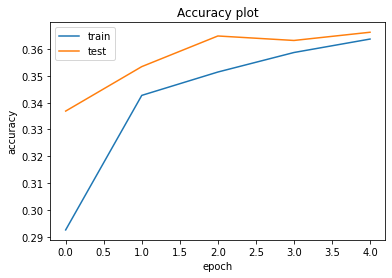

In [ ]:
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.title("Accuracy plot")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.savefig("vgg19v2_accuracy.png")

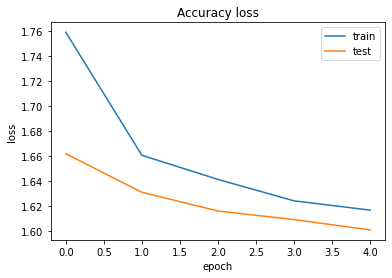

In [ ]:
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.title("Accuracy loss")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.savefig("vgg19v2_loss.png")

We can notice that the accuracy is increasing as the number of epochs is increasing and loss is decreasing as the epochs is increasing

In [ ]:
model.save("vgg19v2.h5")

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,3)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
    
model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten()) 
model.add(Dense(256,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
    
model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

model.compile(
    optimizer = "adam", 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
  )

In [ ]:
hist = model.fit_generator(training_set, validation_data = testing_set , epochs = 5)

Epoch 1/5


<ipython-input-19-427e66dfd6c7>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(training_set, validation_data = testing_set , epochs = 5)


113/113 [==============================] - 22s 155ms/step - loss: 6.9532 - accuracy: 0.2085 - val_loss: 4.3437 - val_accuracy: 0.2471
Epoch 2/5
113/113 [==============================] - 16s 138ms/step - loss: 2.9199 - accuracy: 0.2714 - val_loss: 2.8901 - val_accuracy: 0.2471
Epoch 3/5
113/113 [==============================] - 16s 137ms/step - loss: 2.2540 - accuracy: 0.3480 - val_loss: 3.4750 - val_accuracy: 0.2444
Epoch 4/5
113/113 [==============================] - 15s 136ms/step - loss: 2.2398 - accuracy: 0.4128 - val_loss: 2.7941 - val_accuracy: 0.3224
Epoch 5/5
113/113 [==============================] - 15s 136ms/step - loss: 2.1175 - accuracy: 0.4610 - val_loss: 2.5302 - val_accuracy: 0.3624


In [ ]:
hist = hist.history

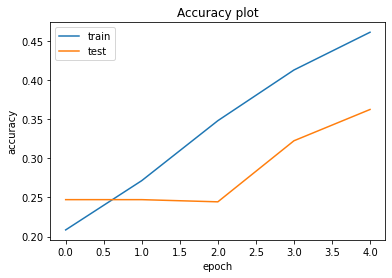

In [ ]:
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.title("Accuracy plot")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.savefig("CNNv2_accuracy.png")

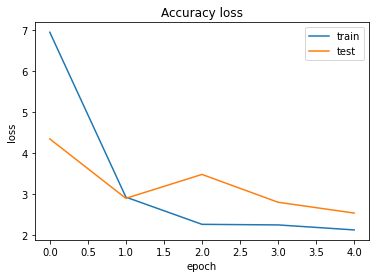

In [ ]:
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.title("Accuracy loss")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.savefig("CNNv2_loss.png")

In [ ]:
model.save("CNNv2.h5")

In [ ]:
# Initialize image data generator with rescaling
train_data_gen = ImageDataGenerator(rescale=1./255)
validation_data_gen = ImageDataGenerator(rescale=1./255)

# Preprocess all test images
train_generator = train_data_gen.flow_from_directory(
        '/content/train',
        target_size=(48, 48),
        batch_size=64,
#         color_mode="grayscale",
        class_mode='categorical')

# Preprocess all train images
validation_generator = validation_data_gen.flow_from_directory(
        '/content/test',
        target_size=(48, 48),
        batch_size=64,
#         color_mode="grayscale",
        class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
dim = (48,48) # for MobileNetV2
n_sequence = 8 # for LSTM
n_channels = 3 # color channel(RGB)
n_output = 7 #18 # number of output class

In [ ]:
model = Sequential()    
model.add(tf.keras.layers.Reshape((1, 48, 48, 3), input_shape=(48, 48, 3)))
model.add( 
    TimeDistributed(
        MobileNetV2(weights='imagenet',include_top=False), 
        input_shape=(n_sequence, *dim, n_channels)
    )
)
model.add(
    TimeDistributed(
        GlobalAveragePooling2D()
    )
)
model.add(CuDNNLSTM(64, return_sequences=False))
model.add(Dense(64, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(24, activation='relu'))
model.add(Dropout(.5))  
model.add(Dense(n_output, activation='softmax'))

# model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
# opt = Adam(lr=0.0001)
model.compile(optimizer = "adam",loss = "categorical_crossentropy" , metrics=['accuracy'])
# model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# hist = model.fit_generator(train_generator, validation_data = validation_generator , epochs = 20)
hist = model.fit_generator(training_set, validation_data = testing_set , epochs = 25)

Epoch 1/25


<ipython-input-28-3217f1617516>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(training_set, validation_data = testing_set , epochs = 25)


113/113 [==============================] - 25s 146ms/step - loss: 1.8297 - accuracy: 0.2415 - val_loss: 1.7659 - val_accuracy: 0.2829
Epoch 2/25
113/113 [==============================] - 14s 124ms/step - loss: 1.6303 - accuracy: 0.3591 - val_loss: 1.7709 - val_accuracy: 0.2891
Epoch 3/25
113/113 [==============================] - 14s 126ms/step - loss: 1.5107 - accuracy: 0.4274 - val_loss: 1.7471 - val_accuracy: 0.3557
Epoch 4/25
113/113 [==============================] - 14s 127ms/step - loss: 1.4291 - accuracy: 0.4635 - val_loss: 1.5326 - val_accuracy: 0.4246
Epoch 5/25
113/113 [==============================] - 14s 125ms/step - loss: 1.3905 - accuracy: 0.4778 - val_loss: 1.5885 - val_accuracy: 0.4539
Epoch 6/25
113/113 [==============================] - 15s 132ms/step - loss: 1.3451 - accuracy: 0.4946 - val_loss: 1.4004 - val_accuracy: 0.4763
Epoch 7/25
113/113 [==============================] - 14s 126ms/step - loss: 1.3187 - accuracy: 0.5107 - val_loss: 1.4661 - val_accuracy: 0.4

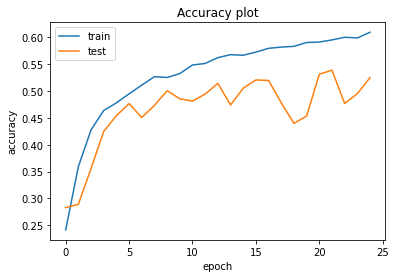

In [ ]:
hist = hist.history
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.title("Accuracy plot")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.savefig("mobilenetCuDNNLSTMv3_accuracy.png")

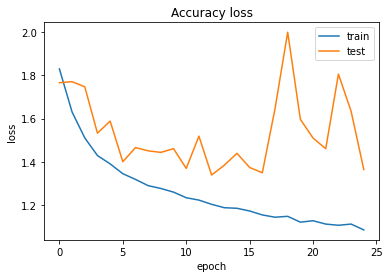

In [ ]:
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.title("Accuracy loss")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.savefig("mobilenetCuDNNLSTMv3_loss.png")

In [ ]:
model.save("mobilenetCuDNNLSTMv3.h5")

In [ ]:
model = Sequential()    
model.add(tf.keras.layers.Reshape((1, 48, 48, 3), input_shape=(48, 48, 3)))
model.add( 
    TimeDistributed(
        MobileNetV2(weights='imagenet',include_top=False), 
        input_shape=(n_sequence, *dim, n_channels)
    )
)
model.add(
    TimeDistributed(
        GlobalAveragePooling2D()
    )
)
model.add(CuDNNLSTM(128,return_sequences = True))
model.add(Dropout(0.2))

model.add(CuDNNLSTM(128))
model.add(Dropout(0.2))

model.add(Dense(32,activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(7,activation = 'softmax'))

# opt = tf.keras.optimizers.Adam(lr = 1e-3,decay = 1e-5)
# model.compile(optimizer = opt,loss = "categorical_crossentropy" , metrics=['accuracy'])

# model.add(CuDNNLSTM(64, return_sequences=False))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(.5))
# model.add(Dense(24, activation='relu'))
# model.add(Dropout(.5))  
# model.add(Dense(n_output, activation='softmax'))

model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
hist = model.fit_generator(train_generator, validation_data = validation_generator , epochs = 20)
hist = hist.history

Epoch 1/20


<ipython-input-33-668f1bc7b638>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(train_generator, validation_data = validation_generator , epochs = 20)


449/449 [==============================] - 30s 52ms/step - loss: 1.8778 - accuracy: 0.2414 - val_loss: 1.8421 - val_accuracy: 0.2471
Epoch 2/20
449/449 [==============================] - 22s 50ms/step - loss: 1.8271 - accuracy: 0.2513 - val_loss: 1.8245 - val_accuracy: 0.2471
Epoch 3/20
449/449 [==============================] - 22s 48ms/step - loss: 1.8121 - accuracy: 0.2513 - val_loss: 1.8132 - val_accuracy: 0.2471
Epoch 4/20
449/449 [==============================] - 21s 48ms/step - loss: 1.7845 - accuracy: 0.2572 - val_loss: 1.7657 - val_accuracy: 0.2778
Epoch 5/20
449/449 [==============================] - 21s 48ms/step - loss: 1.7062 - accuracy: 0.3092 - val_loss: 1.6554 - val_accuracy: 0.3149
Epoch 6/20
449/449 [==============================] - 22s 48ms/step - loss: 1.5951 - accuracy: 0.3663 - val_loss: 1.5621 - val_accuracy: 0.3764
Epoch 7/20
449/449 [==============================] - 22s 48ms/step - loss: 1.4925 - accuracy: 0.4282 - val_loss: 1.5007 - val_accuracy: 0.4203
Epo

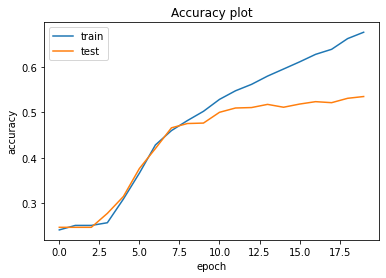

In [ ]:
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.title("Accuracy plot")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.savefig("mobilenetCuDNNLSTMv2_accuracy.png")

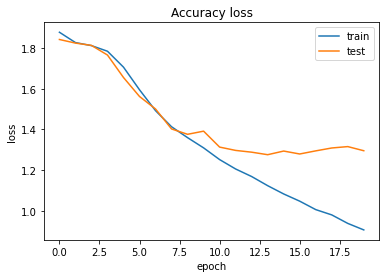

In [ ]:
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.title("Accuracy loss")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.savefig("mobilenetCuDNNLSTMv2_loss.png")

In [ ]:
model.save("mobilenetCuDNNLSTMv2.h5")

In [ ]:
# create model structure
emotion_model = Sequential()

emotion_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 3)))
emotion_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Flatten())
emotion_model.add(Dense(1024, activation='relu'))
emotion_model.add(Dropout(0.5))
emotion_model.add(Dense(7, activation='softmax'))

cv2.ocl.setUseOpenCL(False)

emotion_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001, decay=1e-6), metrics=['accuracy'])

# Train the neural network/model
emotion_model_info = emotion_model.fit_generator(
        train_generator,
        steps_per_epoch=28709 // 64,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=7178 // 64)

# save trained model weight in .h5 file
emotion_model.save('emotion_model.h5')

Epoch 1/50


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
<ipython-input-37-a8ca7f66df07>:25: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  emotion_model_info = emotion_model.fit_generator(


448/448 [==============================] - 14s 30ms/step - loss: 1.7870 - accuracy: 0.2698 - val_loss: 1.6652 - val_accuracy: 0.3605
Epoch 2/50
448/448 [==============================] - 13s 29ms/step - loss: 1.6042 - accuracy: 0.3799 - val_loss: 1.5184 - val_accuracy: 0.4226
Epoch 3/50
448/448 [==============================] - 14s 32ms/step - loss: 1.5032 - accuracy: 0.4215 - val_loss: 1.4361 - val_accuracy: 0.4552
Epoch 4/50
448/448 [==============================] - 13s 30ms/step - loss: 1.4229 - accuracy: 0.4564 - val_loss: 1.3706 - val_accuracy: 0.4813
Epoch 5/50
448/448 [==============================] - 13s 29ms/step - loss: 1.3585 - accuracy: 0.4849 - val_loss: 1.3374 - val_accuracy: 0.4901
Epoch 6/50
448/448 [==============================] - 13s 29ms/step - loss: 1.3050 - accuracy: 0.5059 - val_loss: 1.2708 - val_accuracy: 0.5166
Epoch 7/50
448/448 [==============================] - 13s 29ms/step - loss: 1.2622 - accuracy: 0.5233 - val_loss: 1.2420 - val_accuracy: 0.5232
Epo

In [ ]:
hist = emotion_model_info.history

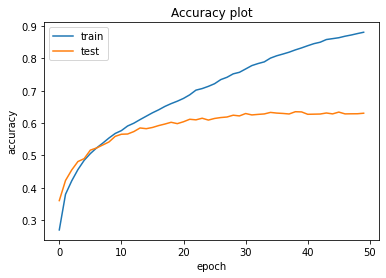

In [ ]:
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.title("Accuracy plot")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.savefig("emotion_model_accuracy.png")

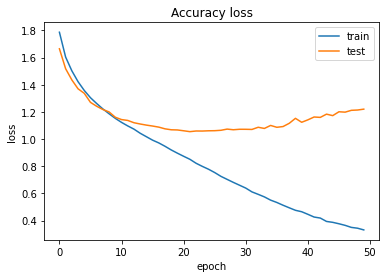

In [ ]:
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.title("Accuracy loss")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.savefig("emotion_model_loss.png")

In [ ]:
model = Sequential()    
model.add(tf.keras.layers.Reshape((1, 48, 48, 3), input_shape=(48, 48, 3)))
model.add( 
    TimeDistributed(
        MobileNetV2(weights='imagenet',include_top=False), 
        input_shape=(n_sequence, *dim, n_channels)
    )
)
model.add(
    TimeDistributed(
        GlobalAveragePooling2D()
    )
)
model.add(CuDNNLSTM(128,return_sequences = True))
model.add(Dropout(0.2))

model.add(CuDNNLSTM(128))
model.add(Dropout(0.2))

model.add(Dense(32,activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(7,activation = 'softmax'))

cv2.ocl.setUseOpenCL(False)

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001, decay=1e-6), metrics=['accuracy'])

# Train the neural network/model
hist = model.fit_generator(
        train_generator,
        steps_per_epoch=28709 // 64,
        epochs=30,
        validation_data=validation_generator,
        validation_steps=7178 // 64)


Epoch 1/30


<ipython-input-41-69f4058f7d76>:30: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


448/448 [==============================] - 31s 54ms/step - loss: 1.7927 - accuracy: 0.2666 - val_loss: 1.7890 - val_accuracy: 0.3334
Epoch 2/30
448/448 [==============================] - 22s 48ms/step - loss: 1.5006 - accuracy: 0.4340 - val_loss: 1.6108 - val_accuracy: 0.3883
Epoch 3/30
448/448 [==============================] - 22s 48ms/step - loss: 1.3460 - accuracy: 0.5019 - val_loss: 1.4841 - val_accuracy: 0.4587
Epoch 4/30
448/448 [==============================] - 22s 48ms/step - loss: 1.2381 - accuracy: 0.5444 - val_loss: 1.3803 - val_accuracy: 0.4994
Epoch 5/30
448/448 [==============================] - 22s 48ms/step - loss: 1.1481 - accuracy: 0.5885 - val_loss: 1.2702 - val_accuracy: 0.5368
Epoch 6/30
448/448 [==============================] - 26s 57ms/step - loss: 1.0673 - accuracy: 0.6222 - val_loss: 1.2488 - val_accuracy: 0.5303
Epoch 7/30
448/448 [==============================] - 22s 48ms/step - loss: 0.9893 - accuracy: 0.6489 - val_loss: 1.2203 - val_accuracy: 0.5462
Epo

In [ ]:
hist = hist.history

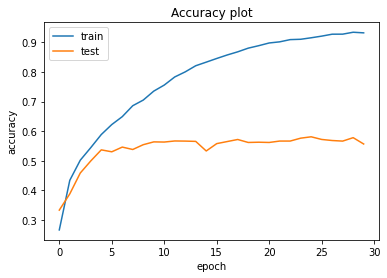

In [ ]:
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.title("Accuracy plot")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.savefig("mobilenetCuDNNLSTMv4_accuracy.png")

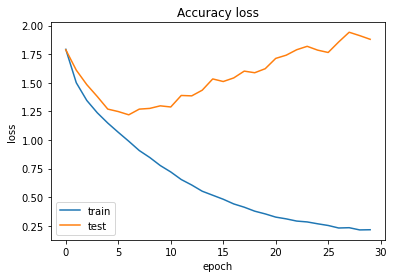

In [ ]:
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.title("Accuracy loss")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.savefig("mobilenetCuDNNLSTMv4_loss.png")

In [ ]:
model.save("mobilenetCuDNNLSTMv4.h5")